In [39]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import zipfile
import os

# Define the ZIP file name (ensure it exists in the same directory or provide the full path)
zip_file_name = "PlantVillage.zip"

# Verify the ZIP file exists
if not os.path.exists(zip_file_name):
    raise FileNotFoundError(f"The file '{zip_file_name}' does not exist.")

# Create a directory to extract files
extract_path = "PlantVillage"
os.makedirs(extract_path, exist_ok=True)

# Extract ZIP file
try:
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Files extracted to {extract_path}")
except zipfile.BadZipFile:
    print(f"The file '{zip_file_name}' is not a valid ZIP file.")


Files extracted to PlantVillage


In [42]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [43]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [44]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [45]:
len(dataset) # 68 which are batches

68

In [46]:
68*32 # Give you Number of images

2176

In [47]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 0]


In [48]:
print(image_batch[0].shape)

(256, 256, 3)


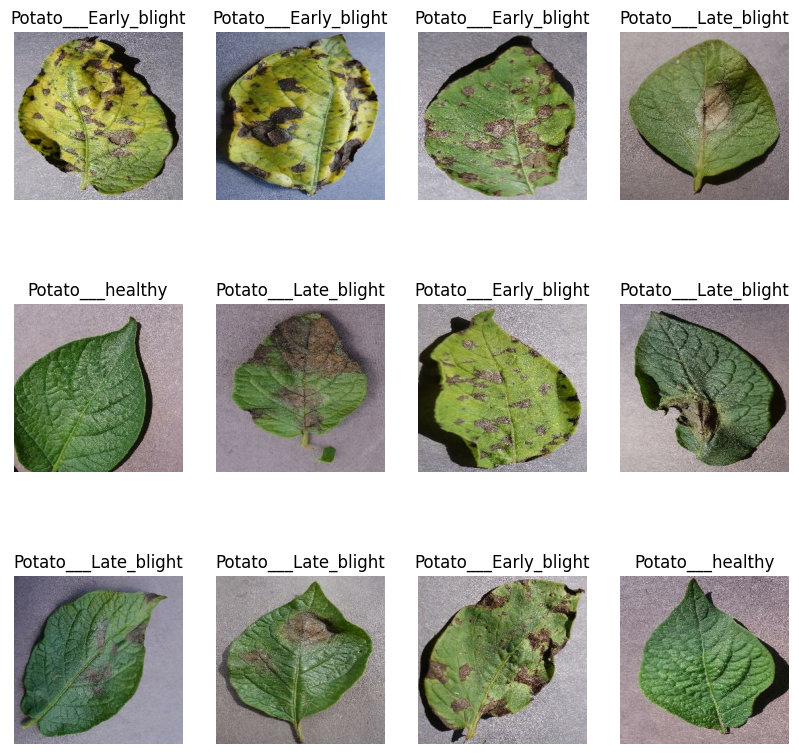

In [49]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1): # Each batch has 32 images
  for i in range(12): # Out of 32 we see or plot only 12 images
    ax = plt.subplot(3,4,i+1) # Making a subplot with 3 rows and 4 columns and i+1 is position which is due to loop start from Zero
    plt.imshow(image_batch[i].numpy().astype("uint8")) # images are by default in float
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

In [50]:
len(dataset) # Batches

68

In [51]:
# 80% --> Training
# 20% --> 10% Validation after each EPOCH , 10% Test after all EPOCHS

In [52]:
train_size = 0.8
len(dataset)*train_size # Get training dataset

54.400000000000006

In [53]:
train_ds = dataset.take(54)
len(train_ds)

54

In [54]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [55]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [56]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [57]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [58]:
# The shuffle operation in this function is used to randomize the order of the dataset before splitting it into training, validation, and test sets. This is important because, without shuffling, the data would be split in its original order, which might lead to a biased split (e.g., if the data is sorted or grouped in some way). By shuffling the data, the model gets a more diverse and representative training, validation, and test set, helping it generalize better.
# When the shuffle_size is set to 1000 in the ds.shuffle(shuffle_size, seed=12) operation, it means that 1000 elements from the dataset will be randomly selected and shuffled in memory before they are passed to the model.

In [59]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12) # seed is random_state same

    train_size = int(train_split * ds_size)

    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)

    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [60]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [61]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # optimize the training
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [62]:
# The reason for using 1.0 (a floating-point number) instead of 1 (an integer) is to ensure that the division operation results in a floating-point value. In Python, dividing by an integer can sometimes result in integer division if not explicitly handled, but using 1.0 guarantees that the operation is performed in floating-point arithmetic, which is necessary for proper scaling.

In [63]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)  # Make image in range [0,1]
])


In [64]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [65]:
# After data augmentation, the original images themselves do not change. Instead, new images are created with changes.

In [66]:
train_ds = train_ds.map( # map apply all this lambda function to ALL IMAGES
    lambda x, y: (data_augmentation(x, training=True), y) # The training=True argument ensures that the augmentation is applied only during training, not during evaluation or inference. This can be important, as you might not want to apply augmentation during validation/testing to preserve the original data.
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [67]:
n_classes = 3

model = models.Sequential([
    layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  # Define input shape explicitly
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) # Initilaize model weights and its architecture

In [68]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [70]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 538ms/step - accuracy: 0.4870 - loss: 0.9187 - val_accuracy: 0.6146 - val_loss: 0.8375
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 421ms/step - accuracy: 0.7074 - loss: 0.6328 - val_accuracy: 0.8073 - val_loss: 0.4724
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 392ms/step - accuracy: 0.7801 - loss: 0.4694 - val_accuracy: 0.9062 - val_loss: 0.3173
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 424ms/step - accuracy: 0.8318 - loss: 0.4008 - val_accuracy: 0.9115 - val_loss: 0.2528
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 393ms/step - accuracy: 0.8409 - loss: 0.3964 - val_accuracy: 0.8906 - val_loss: 0.2932
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 421ms/step - accuracy: 0.8860 - loss: 0.2800 - val_accuracy: 0.9427 - val_loss: 0.2084
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 395ms/step - accuracy: 0.9092 - loss: 0.2258 - val_accuracy: 0.9115 - val_loss: 0.2137
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 423ms/step - accuracy: 0.9299 - loss: 0.1883 - val_accu

In [71]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9936 - loss: 0.0268


In [72]:
scores

[0.022344080731272697, 0.99609375]

In [73]:
history

In [74]:
history.params


{'verbose': 1, 'epochs': 30, 'steps': 54}

In [75]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [76]:
history.history['accuracy']

[0.5387731194496155,
 0.7361111044883728,
 0.7986111044883728,
 0.8356481194496155,
 0.8379629850387573,
 0.8987268805503845,
 0.9056712985038757,
 0.9259259104728699,
 0.9137731194496155,
 0.9363425970077515,
 0.9513888955116272,
 0.9415509104728699,
 0.9565972089767456,
 0.9716435074806213,
 0.9745370149612427,
 0.9785879850387573,
 0.9751157164573669,
 0.9745370149612427,
 0.9565972089767456,
 0.96875,
 0.9710648059844971,
 0.9716435074806213,
 0.9826388955116272,
 0.9791666865348816,
 0.984375,
 0.9832175970077515,
 0.9791666865348816,
 0.9774305820465088,
 0.9918981194496155,
 0.9918981194496155]

In [77]:
len(history.history['accuracy'])

30

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

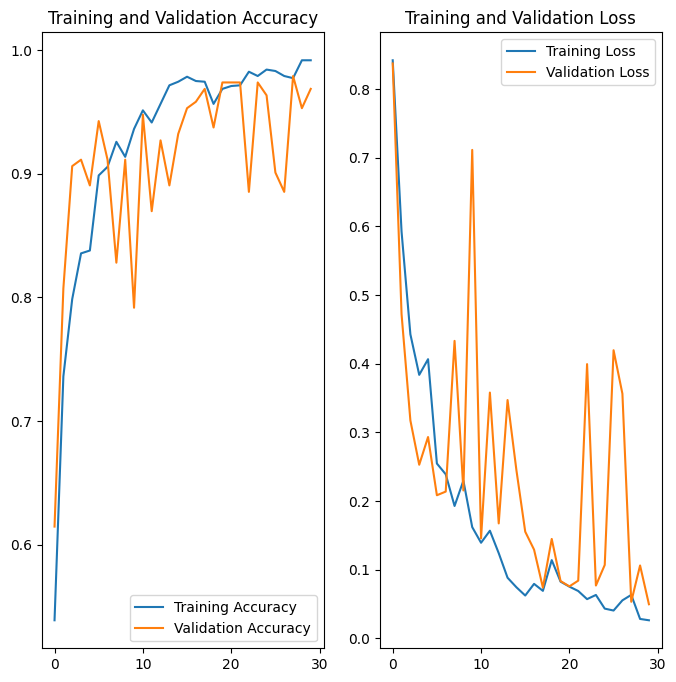

In [79]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1) # 1 row and 2 columns in 1st subplot
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2) # 1 row and 2 columns in 2st subplot
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

first image to predict
actual label: Potato___Late_blight
Predicted Lables : Potato___Late_blight


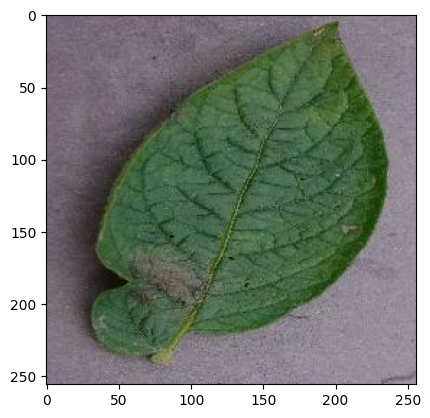

In [80]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:",class_names[first_label])

  batch_prediction = model.predict(images_batch,verbose=0)
  print("Predicted Lables :",class_names[np.argmax(batch_prediction[0])])





In [81]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())

    # images[i].numpy(): Converts the image (likely from a dataset or tensor) into a NumPy array.
    # tf.keras.preprocessing.image.img_to_array(): Converts the NumPy array into a format compatible with Keras. It ensures that the image data is correctly represented as a 3D array of pixel values (for a single image).

    img_array = tf.expand_dims(img_array, 0) # tf.expand_dims(input, axis) and axis = 0

    # axis = 0 : Specifies that the new dimension should be added at the 0th position (the beginning of the array).

    # Why Add a Dimension?
    # Deep learning models often expect input data to have a batch structure. Even if you're predicting for a single image, the model still expects it to be in the form of a batch. By adding a batch dimension:
    # The batch_size is automatically taken by model as 32 images per batch

    predictions = model.predict(img_array,verbose=0)

    prediction_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    # The confidence value indicates how strongly the model believes that its predicted class is correct, based on the probabilities it assigned to all possible classes

    return prediction_class, confidence

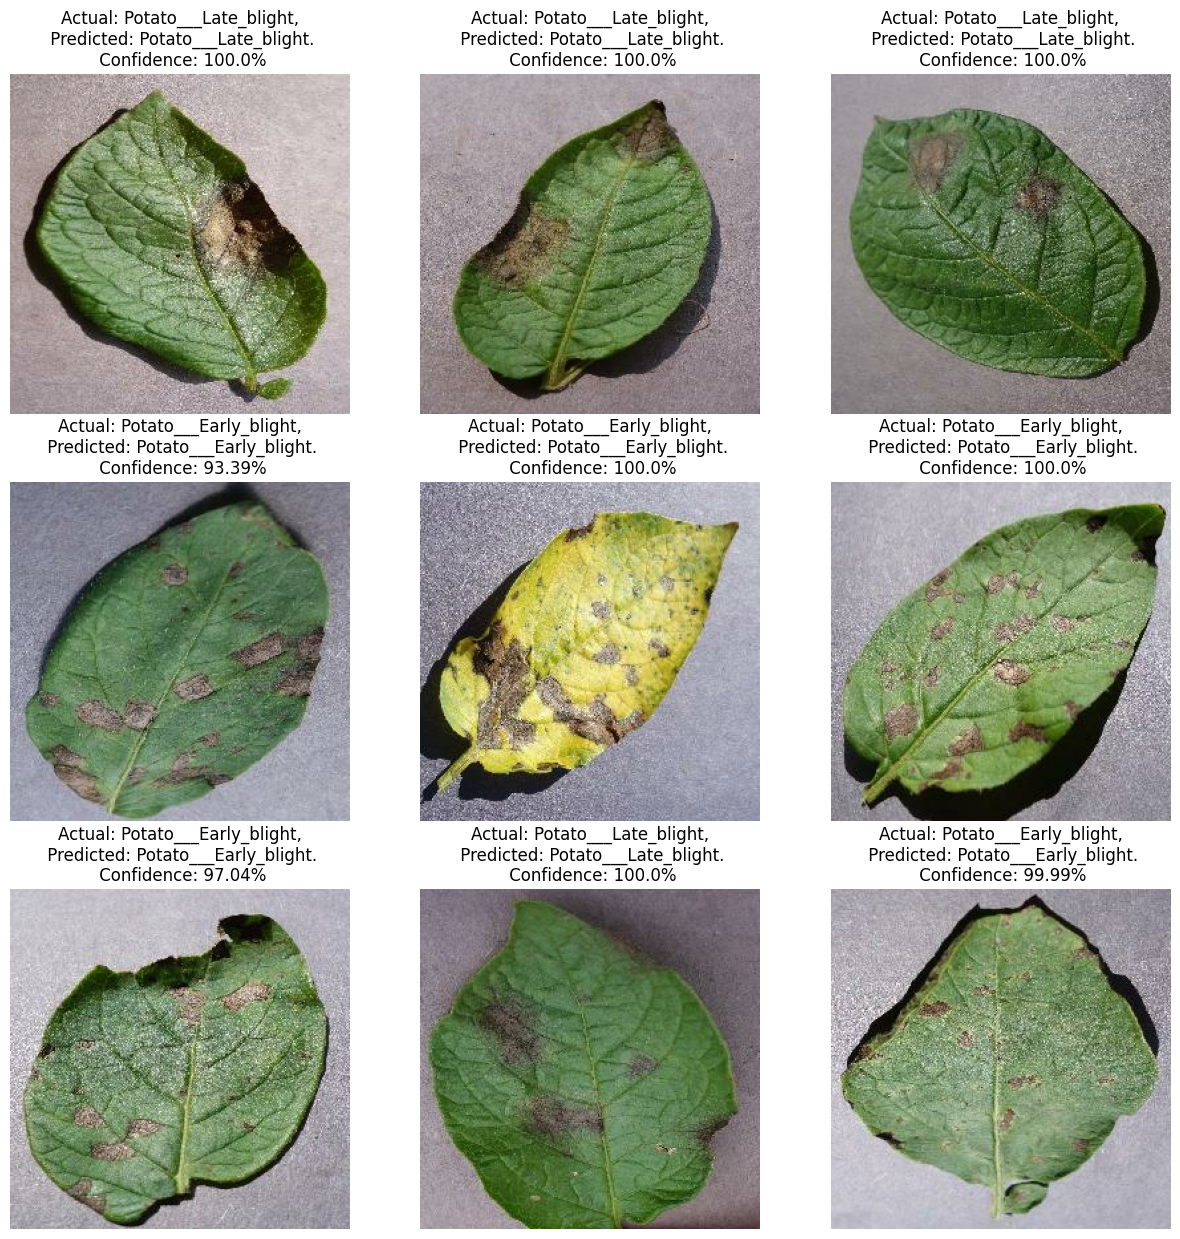

In [82]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [103]:
import os

# Define the directory path in Google Drive
directory_path = "/content/drive/MyDrive/Next/models"

# Create the directory if it doesn't exist
os.makedirs(directory_path, exist_ok=True)

# Get the highest version number of existing models in the directory
model_versions = [ # AutoIncrement the model_versions whenever run this cell
    int(file.split('.')[0]) for file in os.listdir(directory_path) if file.endswith(".keras") and file.split('.')[0].isdigit()
]

# Determine the new version number
if model_versions:
    model_version = max(model_versions) + 1
else:
    model_version = 1  # Start with version 1 if no models exist

# Save the model inside the 'models' folder
model.save(f"{directory_path}/{model_version}.keras")  # Native Keras format

print(f"Model saved as version {model_version}.keras")


Model saved as version 2.h5
